Follows $\texttt{https://github.com/ericmetodiev/OmniFold/blob/master/OmniFold\%20Demo.ipynb}$ but uses pip-installable version of OmniFold

In [4]:
!"module load anaconda"

/bin/bash: module load anaconda: command not found


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import copy

import energyflow as ef # for data
import omnifold # for omnifold algorithm

# Local imports for plotting (source: https://github.com/ericmetodiev/OmniFold/blob/master/modplot.py)
import modplot
from hist_utils import obs, calc_obs, hist_style, gen_style, truth_style, omnifold_style

plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'serif'

# Global variables
LAYER_SIZES = [64, 128, 64]
OBS_MULTIFOLD = ['Mass', 'Mult', 'Width', 'Tau21', 'zg', 'SDMass']
N_DATA = int(5e5)
N_ITER = 3
BATCH_SIZE = 500
EPOCHS = 2
N_JOBS = 16

np.random.seed(0)
import tensorflow as tf
tf.random.set_seed(0)

ModuleNotFoundError: No module named 'energyflow'

In [2]:
print(f'\nTensorflow version = {tf.__version__}\n')
print(f'\n{tf.config.list_physical_devices("GPU")}\n')


Tensorflow version = 2.15.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]



# 1. Load data

We assume, for simplicity:
1. That everything passes the reco and gen cuts
2. That the data is already normalized
3. That the data is uniformly weighted, to begin

We choose Pythia as the Monte Carlo data

In [3]:
data_mc_dict = ef.zjets_delphes.load('Pythia26', num_data=N_DATA, pad=True, source='zenodo', which='all')
obs_mc_gen = {k.replace("gen_", ""): data_mc_dict[k] for k in data_mc_dict.keys() if (('gen_' in k) and ('particle' not in k))}
particle_mc_gen = data_mc_dict['gen_particles']
obs_mc_sim = {k.replace("sim_", ""): data_mc_dict[k] for k in data_mc_dict.keys() if (('sim_' in k) and ('particle' not in k))}
particle_mc_sim = data_mc_dict['sim_particles']

obs_mc_gen['Mass'] = obs_mc_gen['jets'][:,3]
obs_mc_gen.pop('jets')
obs_mc_gen['Mult'] = obs_mc_gen.pop('mults')
obs_mc_gen['Width'] = obs_mc_gen.pop('widths')
obs_mc_gen['Tau21'] = obs_mc_gen.pop('tau2s')
obs_mc_gen['zg'] = obs_mc_gen.pop('zgs')
obs_mc_gen['SDMass'] = obs_mc_gen.pop('sdms')
obs_mc_gen = np.concatenate([obs_mc_gen[k].reshape((N_DATA,1)) for k in OBS_MULTIFOLD], axis=1)

obs_mc_sim['Mass'] = obs_mc_sim['jets'][:,3]
obs_mc_sim.pop('jets')
obs_mc_sim['Mult'] = obs_mc_sim.pop('mults')
obs_mc_sim['Width'] = obs_mc_sim.pop('widths')
obs_mc_sim['Tau21'] = obs_mc_sim.pop('tau2s')
obs_mc_sim['zg'] = obs_mc_sim.pop('zgs')
obs_mc_sim['SDMass'] = obs_mc_sim.pop('sdms')
obs_mc_sim = np.concatenate([obs_mc_sim[k].reshape((N_DATA,1)) for k in OBS_MULTIFOLD], axis=1)

And Hedwig as the true/nature data

In [4]:
data_nature_dict = ef.zjets_delphes.load('Herwig', num_data=N_DATA, pad=True, source='zenodo', which='all')
obs_nature_gen = {k.replace("gen_", ""): data_nature_dict[k] for k in data_nature_dict.keys() if (('gen_' in k) and ('particle' not in k))}
particle_nature_gen = data_nature_dict['gen_particles']
obs_nature_sim = {k.replace("sim_", ""): data_nature_dict[k] for k in data_nature_dict.keys() if (('sim_' in k) and ('particle' not in k))}
particle_nature_sim = data_nature_dict['sim_particles']

obs_nature_gen['Mass'] = obs_nature_gen['jets'][:,3]
obs_nature_gen.pop('jets')
obs_nature_gen['Mult'] = obs_nature_gen.pop('mults')
obs_nature_gen['Width'] = obs_nature_gen.pop('widths')
obs_nature_gen['Tau21'] = obs_nature_gen.pop('tau2s')
obs_nature_gen['zg'] = obs_nature_gen.pop('zgs')
obs_nature_gen['SDMass'] = obs_nature_gen.pop('sdms')
obs_nature_gen = np.concatenate([obs_nature_gen[k].reshape((N_DATA,1)) for k in OBS_MULTIFOLD], axis=1)

obs_nature_sim['Mass'] = obs_nature_sim['jets'][:,3]
obs_nature_sim.pop('jets')
obs_nature_sim['Mult'] = obs_nature_sim.pop('mults')
obs_nature_sim['Width'] = obs_nature_sim.pop('widths')
obs_nature_sim['Tau21'] = obs_nature_sim.pop('tau2s')
obs_nature_sim['zg'] = obs_nature_sim.pop('zgs')
obs_nature_sim['SDMass'] = obs_nature_sim.pop('sdms')
obs_nature_sim = np.concatenate([obs_nature_sim[k].reshape((N_DATA,1)) for k in OBS_MULTIFOLD], axis=1)

### Construct dataloader objects

In [5]:
# Pad both sets of reco/gen to the same size (number of particles per event)

N_PART_GEN = max(particle_mc_gen.shape[1], particle_nature_gen.shape[1])
N_PART_SIM = max(particle_mc_sim.shape[1], particle_nature_sim.shape[1])
particle_mc_gen = np.concatenate([particle_mc_gen, np.zeros((particle_mc_gen.shape[0], N_PART_GEN-particle_mc_gen.shape[1], 4))], axis=1)
particle_nature_gen = np.concatenate([particle_nature_gen, np.zeros((particle_nature_gen.shape[0], N_PART_GEN-particle_nature_gen.shape[1], 4))], axis=1)
particle_mc_sim = np.concatenate([particle_mc_sim, np.zeros((particle_mc_sim.shape[0], N_PART_SIM-particle_mc_sim.shape[1], 4))], axis=1)
particle_nature_sim = np.concatenate([particle_nature_sim, np.zeros((particle_nature_sim.shape[0], N_PART_SIM-particle_nature_sim.shape[1], 4))], axis=1)

# Construct DataLoaders
obs_mc = omnifold.DataLoader(reco=copy.deepcopy(obs_mc_sim), gen=copy.deepcopy(obs_mc_gen))
particle_mc = omnifold.DataLoader(reco=copy.deepcopy(particle_mc_sim), gen=copy.deepcopy(particle_mc_gen))

# Construct DataLoaders
obs_nature = omnifold.DataLoader(reco=copy.deepcopy(obs_nature_sim), gen=copy.deepcopy(obs_nature_gen))
particle_nature = omnifold.DataLoader(reco=copy.deepcopy(particle_nature_sim), gen=copy.deepcopy(particle_nature_gen))

del obs_mc_sim, obs_mc_gen, particle_mc_sim, particle_mc_gen
del obs_nature_sim, obs_nature_gen, particle_nature_sim, particle_nature_gen 

INFO: Creating weights ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...
INFO: Creating weights ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...
INFO: Creating weights ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...
INFO: Creating weights ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...


For plotting

In [6]:
calc_obs(obs_dict=obs, data_synth=data_mc_dict, data_real=data_nature_dict)
del data_mc_dict, data_nature_dict

Done with Mass
Done with Mult
Done with Width
Done with Tau21
Done with zg
Done with SDMass


# 2. Run OmniFold

In [7]:
import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # Keeps us from killing kernel due to memory
# os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'
N_FEAT_RECO = particle_mc.reco.shape[2]
N_PART_RECO = particle_mc.reco.shape[1]
N_FEAT_GEN = particle_mc.gen.shape[2]
N_PART_GEN = particle_mc.gen.shape[1]
name = "OmniFold"

# model_of_reco = PET(num_feat=N_FEAT, num_jet=2, num_classes=2)

model_of_reco = omnifold.net.PET(num_feat = N_FEAT_RECO, num_evt = 0, num_part = N_PART_RECO)
# model_of_gen = omnifold.net.MLP(nvars = len(OBS_MULTIFOLD), layer_sizes=LAYER_SIZES)
model_of_gen = omnifold.net.PET(num_feat = N_FEAT_GEN, num_evt=0, num_part=N_PART_GEN)

model_of = omnifold.MultiFold(
    name=name, 
    model_reco=model_of_reco, 
    model_gen=model_of_gen, 
    data=particle_nature, 
    mc=particle_mc, 
    niter=N_ITER,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    size=N_JOBS)

model_of.Unfold()

2025-03-28 12:17:12.833915: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38367 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


125 training steps at reco and 125 steps at gen
ITERATION: 1
RUNNING STEP 1


/global/homes/a/aelabd/.conda/envs/omnifold/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Training:   0%|           0/2 ETA: ?s,  ?epochs/s

Epoch 1/2


2025-03-28 12:17:38.462496: I external/local_xla/xla/service/service.cc:168] XLA service 0x7eeaf06169c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-28 12:17:38.462518: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2025-03-28 12:17:38.485001: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-28 12:17:38.567629: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1743189458.695026 1118185 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100/100██████████ ETA: 00:00s - loss: 0.6875 - val_loss: 0.6850 - lr: 0.0001
Training:  50%|█████      1/2 ETA: 00:31s,  31.80s/epochs

Epoch 2/2


100/100██████████ ETA: 00:00s - loss: 0.6843 - val_loss: 0.6840 - lr: 0.0001
Training: 100%|██████████ 2/2 ETA: 00:00s,  20.09s/epochs


Last val loss 0.6849660873413086
INFO: Dumping training history ...
RUNNING STEP 2


Training:   0%|           0/2 ETA: ?s,  ?epochs/s

Epoch 1/2


100/100██████████ ETA: 00:00s - loss: 0.7074 - val_loss: 0.7040 - lr: 0.0001
Training:  50%|█████      1/2 ETA: 00:31s,  31.57s/epochs

Epoch 2/2


100/100██████████ ETA: 00:00s - loss: 0.7045 - val_loss: 0.7038 - lr: 0.0001
Training: 100%|██████████ 2/2 ETA: 00:00s,  20.53s/epochs


Last val loss 0.703993558883667
INFO: Dumping training history ...
ITERATION: 2
RUNNING STEP 1


Training:   0%|           0/2 ETA: ?s,  ?epochs/s

Epoch 1/2


100/100██████████ ETA: 00:00s - loss: 0.7203 - val_loss: 0.7193 - lr: 0.0001
Training:  50%|█████      1/2 ETA: 00:29s,  29.75s/epochs

Epoch 2/2


100/100██████████ ETA: 00:00s - loss: 0.7196 - val_loss: 0.7196 - lr: 0.0001
Training: 100%|██████████ 2/2 ETA: 00:00s,  18.87s/epochs


Last val loss 0.7192999720573425
INFO: Dumping training history ...
RUNNING STEP 2


Training:   0%|           0/2 ETA: ?s,  ?epochs/s

Epoch 1/2


100/100██████████ ETA: 00:00s - loss: 0.7013 - val_loss: 0.7006 - lr: 0.0001
Training:  50%|█████      1/2 ETA: 00:31s,  31.94s/epochs

Epoch 2/2


100/100██████████ ETA: 00:00s - loss: 0.7011 - val_loss: 0.7007 - lr: 0.0001
Training: 100%|██████████ 2/2 ETA: 00:00s,  20.63s/epochs


Last val loss 0.7005904316902161
INFO: Dumping training history ...
ITERATION: 3
RUNNING STEP 1


Training:   0%|           0/2 ETA: ?s,  ?epochs/s

Epoch 1/2


100/100██████████ ETA: 00:00s - loss: 0.6972 - val_loss: 0.6967 - lr: 0.0001
Training:  50%|█████      1/2 ETA: 00:29s,  29.61s/epochs

Epoch 2/2


100/100██████████ ETA: 00:00s - loss: 0.6971 - val_loss: 0.6969 - lr: 0.0001
Training: 100%|██████████ 2/2 ETA: 00:00s,  18.72s/epochs


Last val loss 0.6966636776924133
INFO: Dumping training history ...
RUNNING STEP 2


Training:   0%|           0/2 ETA: ?s,  ?epochs/s

Epoch 1/2


100/100██████████ ETA: 00:00s - loss: 0.6981 - val_loss: 0.6977 - lr: 0.0001
Training:  50%|█████      1/2 ETA: 00:30s,  30.25s/epochs

Epoch 2/2


100/100██████████ ETA: 00:00s - loss: 0.6980 - val_loss: 0.6983 - lr: 0.0001
Training: 100%|██████████ 2/2 ETA: 00:00s,  19.75s/epochs


Last val loss 0.6977127194404602
INFO: Dumping training history ...


# 3. Evaluate

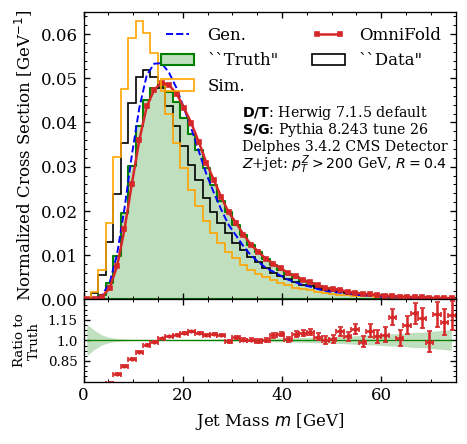

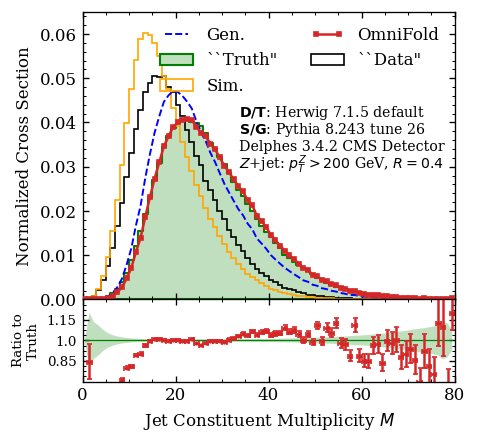

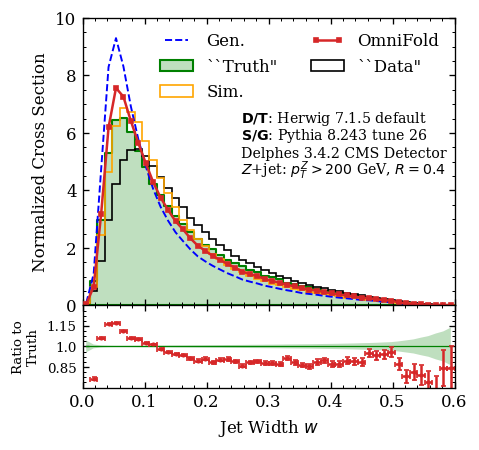

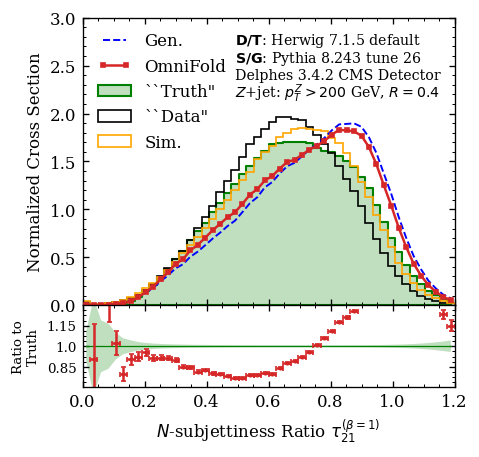

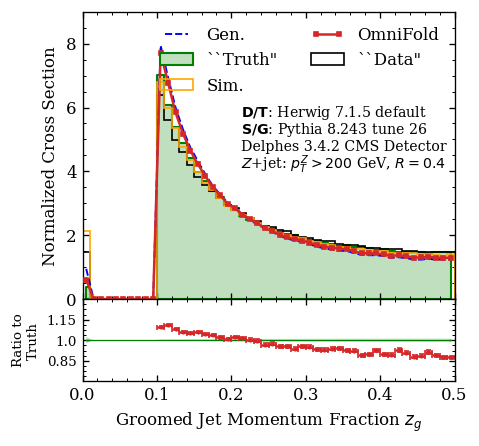

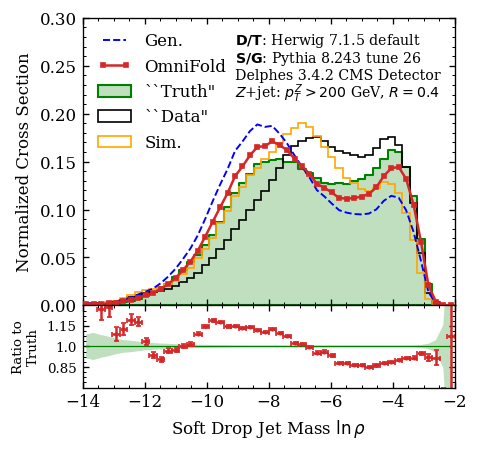

In [8]:
for i,(obkey,ob) in enumerate(obs.items()):
    
    # get the styled axes on which to plot
    fig, [ax0, ax1] = modplot.axes(**ob)
    if ob.get('yscale') is not None:
        ax0.set_yscale(ob['yscale'])
        
    # Plot the Different Distributions of the Observable
    # plot the "data" histogram of the observable
    ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='``Data\"', **hist_style)

    # plot the "sim" histogram of the observable
    ax0.hist(ob['simobs'], bins=ob['bins_det'], color='orange', label='Sim.', **hist_style)

    # plot the "gen" histogram of the observable
    ax0.plot(ob['midbins_mc'], ob['genobs_hist'], **gen_style)

    # plot the "truth" histogram of the observable
    ax0.fill_between(ob['midbins_mc'], ob['truth_hist'], **truth_style)
    
    # Plot the Unfolded Distributions of the Observable
    # plot the OmniFold distribution
    of_histgen, of_histgen_unc = modplot.calc_hist(ob['genobs'], weights=model_of.weights_push, 
                                                   bins=ob['bins_mc'], density=True)[:2]
    ax0.plot(ob['midbins_mc'], of_histgen, **omnifold_style, label='OmniFold')

    # Plot the Ratios of the OmniFold and IBU distributions to truth (with statistical uncertainties)
    of_ratio = of_histgen/(ob['truth_hist'] + 10**-50)
    ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)
    
    # ratio uncertainties
    truth_unc_ratio = ob['truth_hist_unc']/(ob['truth_hist'] + 10**-50)
    of_unc_ratio = of_histgen_unc/(ob['truth_hist'] + 10**-50)
    
    ax1.fill_between(ob['midbins_mc'], 1 - truth_unc_ratio, 1 + truth_unc_ratio, 
                     facecolor=truth_style['facecolor'], zorder=-2)
    ax1.errorbar(ob['midbins_mc'], of_ratio, xerr=ob['binwidth_mc']/2, yerr=of_unc_ratio, 
                                              color=omnifold_style['color'], **modplot.style('errorbar'))

    # legend style and ordering
    loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
    order = [2, 3, 1, 4, 0] if ncol==2 else [2, 4, 3, 0, 1]
    modplot.legend(ax=ax0, frameon=False, order=order, loc=loc, ncol=ncol)

    # stamp to put on the plots
    modplot.stamp(*ob['stamp_xy'], delta_y=0.06, ax=ax0,
                  line_0=r'$\mathbf{D/T}$: Herwig 7.1.5 default',
                  line_1=r'$\mathbf{S/G}$: Pythia 8.243 tune 26',
                  line_2=r'Delphes 3.4.2 CMS Detector',
                  line_3=r'$Z$+jet: $p_T^Z>200$ GeV, $R=0.4$')
    
    # save plot (by default in the same directory as this notebook).
    # If running on binder, the plot can be accessed by first going to the jupyter file browser
    # (which itself can be accessed by copying the URL of this notebook and removing the name of the notebook
    # after the final "/"), selecting the square next to the name of the plot, and clicking "Download".
    fig.savefig('OmniFold_{}.pdf'.format(obkey), bbox_inches='tight')
    plt.show()

In [9]:
np.save(model_of.name + '_weights_push.npy', model_of.weights_push)
np.save(model_of.name + '_weights_pull.npy', model_of.weights_pull)